In [8]:
# Import required packages
import random
import time
from typing import Optional, List, Iterator, Tuple

import matplotlib.pyplot as plt
import numpy as np

In [9]:
def generate_array(length: int, min_value: Optional[int] = None, max_value: Optional[int] = None) -> List[int]:
    if min_value is not None and max_value is not None:
        assert min_value <= max_value, "Min can't be greater than max"

    if min_value is None:
        min_value = -(length ** 2)

    if max_value is None:
        max_value = length ** 2

    return [random.randint(a=min_value, b=max_value) for _ in range(length)]

In [10]:
def heapify(sequence: List[int], length: int, current_index: int) -> None:
    # Find largest among root and children
    largest = current_index
    left_child = 2 * current_index + 1
    right_child = 2 * current_index + 2

    if left_child < length and sequence[current_index] < sequence[left_child]:
        largest = left_child
    if right_child < length and sequence[largest] < sequence[right_child]:
        largest = right_child

    # If root is not largest, swap with largest and continue heapifying
    if largest != current_index:
        sequence[current_index], sequence[largest] = sequence[largest], sequence[current_index]
        heapify(sequence=sequence, length=length, current_index=largest)


def heap_sort(sequence: List[int]) -> None:
    # Build max heap
    for j in range(len(sequence) // 2, -1, -1):
        heapify(sequence=sequence, length=len(sequence), current_index=j)

    for j in range(len(sequence) - 1, 0, -1):
        # Swap elements
        sequence[j], sequence[0] = sequence[0], sequence[j]
        # Heapify root element
        heapify(sequence=sequence, length=j, current_index=0)

In [11]:
def measure_results(array_sizes: Iterator[int]) -> List[float]:
    actual_results = list()

    for size in array_sizes:
        # Generate a randomized array
        randomized_array = generate_array(length=size)

        # Measure sorting execution time
        start_time = time.time()
        heap_sort(sequence=randomized_array)
        end_time = time.time()

        # Record the result
        actual_results.append(end_time - start_time)

    return actual_results


def calculate_coefficients(actual_results: np.ndarray, array_sizes: np.ndarray) -> Tuple[float, float, float]:
    # Calculate main determinant
    n2_log2 = np.sum(np.square(array_sizes) * np.square(np.log2(array_sizes)))
    n2_log = np.sum(np.square(array_sizes) * np.log2(array_sizes))
    n_log = np.sum(array_sizes * np.log2(array_sizes))
    n2 = np.sum(np.square(array_sizes))
    n = np.sum(array_sizes)
    k = array_sizes.shape[0]

    main_det = np.array([
        [n2_log2, n2_log, n_log],
        [n2_log, n2, n],
        [n_log, n, k],
    ])
    main_det = np.linalg.det(main_det)
    assert main_det != 0, "Main determinant is equal to 0, so Cramer's rule cannot be used here"

    # Calculate "a" variable determinant
    t_n_log = np.sum(actual_results * array_sizes * np.log2(array_sizes))
    t_n = np.sum(actual_results * array_sizes)
    t = np.sum(actual_results)

    a_det = np.array([
        [t_n_log, n2_log, n_log],
        [t_n, n2, n],
        [t, n, k],
    ])
    a_det = np.linalg.det(a_det)

    # Calculate "b" variable determinant
    b_det = np.array([
        [n2_log2, t_n_log, n_log],
        [n2_log, t_n, n],
        [n_log, t, k],
    ])
    b_det = np.linalg.det(b_det)

    # Calculate "c" variable determinant
    c_det = np.array([
        [n2_log2, n2_log, t_n_log],
        [n2_log, n2, t_n],
        [n_log, n, t],
    ])
    c_det = np.linalg.det(c_det)

    return a_det / main_det, b_det / main_det, c_det / main_det

In [12]:
experiments_num = 10
sizes = np.linspace(start=100, stop=100_000, num=10, dtype=int)
print(f"Running {experiments_num} experiments with such sizes: {sizes}")

# Collect required information
results = list()
for i in range(experiments_num):
    result = measure_results(array_sizes=sizes)
    results.append(result)

# Find averages
results = np.array(results)
results = np.sum(a=results, axis=0) / experiments_num

# Process data and output results
a, b , c = calculate_coefficients(actual_results=results, array_sizes=sizes)

Running 10 experiments with such sizes: [   100  11200  22300  33400  44500  55600  66700  77800  88900 100000]


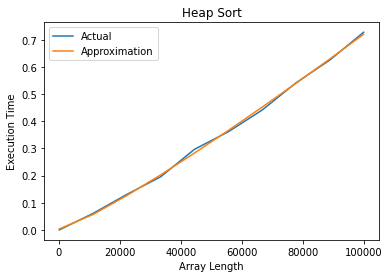

In [13]:
# Let's plot data now, to check if approximation is correct
approximation_data = a * sizes * np.log2(sizes) + b * sizes + c

plt.plot(sizes, results, label="Actual")
plt.plot(sizes, approximation_data, label="Approximation")
plt.xlabel(xlabel="Array Length")
plt.ylabel(ylabel="Execution Time")
plt.title(label="Heap Sort")
plt.legend()

Running 10 experiments with such sizes: [200000 350000 500000]


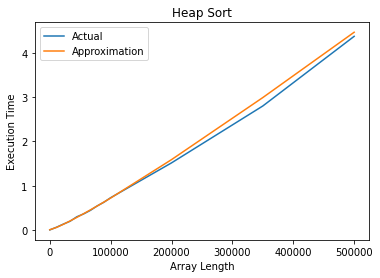

In [14]:
# Now let's try to predict results for new sizes
new_sizes = np.linspace(start=200_000, stop=500_000, num=3, dtype=int)
print(f"Running {experiments_num} experiments with such sizes: {new_sizes}")
new_approximation_data = a * new_sizes * np.log2(new_sizes) + b * new_sizes + c

# Collect required information
new_results = list()
for i in range(experiments_num):
    result = measure_results(array_sizes=new_sizes)
    new_results.append(result)

# Find averages
new_results = np.array(new_results)
new_results = np.sum(a=new_results, axis=0) / experiments_num

# Let's plot old and new data now, to check how approximation differs from original time
sizes = np.append(sizes, new_sizes)
results = np.append(results, new_results)
approximation_data = np.append(approximation_data, new_approximation_data)

plt.plot(sizes, results, label="Actual")
plt.plot(sizes, approximation_data, label="Approximation")
plt.xlabel(xlabel="Array Length")
plt.ylabel(ylabel="Execution Time")
plt.title(label="Heap Sort")
plt.legend()